In [ ]:
import tensorflow as tf
import numpy as np
import tensorflow.keras.datasets as tfds
import tensorflow.keras.layers as layers
from tqdm import tqdm
import matplotlib.pyplot as plt

## Prepare Dataset

In [ ]:
BATCH_SIZE = 64
SHUFFLE = 10000

In [ ]:
def prepare_dataset():
  (train_images, _), _ = tfds.cifar10.load_data()
  print(type(train_images))
  print(len(train_images))
  # It is an ndarray, not a prefetch_op._PrefetchDataset
  train_images = train_images.astype("float32")
  max_val, min_val = np.max(train_images), np.min(train_images)
  train_images = (train_images - min_val) / (max_val/2 - min_val)
  train_images -= 1 # Normalized to [-1, 1]
  train_images = tf.data.Dataset.from_tensor_slices(train_images).shuffle(SHUFFLE).batch(BATCH_SIZE, drop_remainder= True)
  print("After normalizing:")
  print("Type: ", type(train_images), "\nMax " , np.max(train_images), "\nMin ", np.min(train_images))
  return train_images

In [ ]:
train_set = prepare_dataset()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
<class 'numpy.ndarray'>
50000
After normalizing:
Type:  <class 'tensorflow.python.data.ops.batch_op._BatchDataset'> 
Max  <_BatchDataset element_spec=TensorSpec(shape=(64, 32, 32, 3), dtype=tf.float32, name=None)> 
Min  <_BatchDataset element_spec=TensorSpec(shape=(64, 32, 32, 3), dtype=tf.float32, name=None)>


## Architecture

In [ ]:
LEAKY_RELU_SLOPE = 0.2
DROPOUT_RATE = 0.3

In [ ]:
# The generator starts from pure noise, which is a
# 100-size vector
def make_generator():
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape = (100, )))
    model.add(layers.Dense(4 * 4 * 512, use_bias = False))
    # Dense is the aW + b , where b here is 0 because of the immediate batch normalization
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(LEAKY_RELU_SLOPE))
    model.add(layers.Reshape((4, 4, 512)))

    model.add(layers.Conv2DTranspose(filters = 256, kernel_size = 5, strides = 2, padding = 'same', use_bias = False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(LEAKY_RELU_SLOPE))

    model.add(layers.Conv2DTranspose(128, 5, strides = 2, padding = 'same', use_bias = False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(LEAKY_RELU_SLOPE))

    model.add(layers.Conv2DTranspose(3, 5, strides = 2, padding = 'same', use_bias = False, activation = 'tanh'))

    # print(model.summary)
    # To see the model output's shape in each layer
    return model


In [ ]:
def make_critic():
    model = tf.keras.Sequential()
    # (32, 32, 3) is the original cifar_10 size
    model.add(tf.keras.Input(shape = (32, 32, 3)))
    model.add(layers.Conv2D(64, 5, strides = 2, padding = 'same'))
    model.add(layers.LeakyReLU(LEAKY_RELU_SLOPE))
    model.add(layers.Dropout(DROPOUT_RATE))

    model.add(layers.Conv2D(128, 5, strides = 2, padding = 'same'))
    model.add(layers.LeakyReLU(LEAKY_RELU_SLOPE))
    model.add(layers.Dropout(DROPOUT_RATE))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    # print(model.summary)
    return model

## Gradient Penalty

In [ ]:
def gradient_penalty(critic, real_x, gen_x, print_loss_info = False):
    # print("Real shape: ", real_x.shape, "\t Fake shape: ", gen_x.shape)
    # print("Real - Fake images: ", (real_x - gen_x).shape)
    noise_shape = (real_x - gen_x).shape
    noise_shape_2 = gen_x.shape
    # print("Is there any difference? ", noise_shape, noise_shape_2)
    # Check the code [real.shape[0], 1, 1, 1]
    # alpha = tf.random.uniform(noise_shape, 0., 1.)
    alpha_shape = [real_x.shape[0], 1, 1, 1]
    alpha = tf.random.uniform(alpha_shape, 0., 1.)
    # print("Alpha is not simply a coefficient, it is a matrix")
    # print(alpha.shape)
    interpolated_x = alpha * real_x + (tf.ones_like(alpha) - alpha) * gen_x
    # print("What is the difference?")
    # print((tf.ones_like(alpha) - alpha).shape)
    # print((1 - alpha).shape)
    with tf.GradientTape() as tape:
        tape.watch(interpolated_x)
        pred = critic(interpolated_x)
    grads = tape.gradient(pred, [interpolated_x])[0]
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis = [1, 2, 3]))
    if print_loss_info:
        print("Critic output shape: ", pred.shape)
        print("Grads of  GP shape: ", grads.shape)
        print("Norm shape: ", norm.shape)
    # Why [1, 2, 3]? Because the 0 index is batch index
    return tf.reduce_mean((norm - 1.)**2)


## Optimizers

In [ ]:
generator = make_generator()
critic = make_critic()
gen_opt = tf.keras.optimizers.Adam(1e-4, beta_1 = 0.0, beta_2 = 0.9)
critic_opt = tf.keras.optimizers.Adam(1e-4, beta_1 = 0.0, beta_2 = 0.9)

In [ ]:
generator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8192)           │       819,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 8192)           │        32,768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 256)      │     3,276,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 128)    │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 3)      │         9,600 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,959,104 (18.92 MB)

 Trainable params: 4,941,952 (18.85 MB)

 Non-trainable params: 17,152 (67.00 KB)

In [ ]:
critic.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 16, 16, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 217,985 (851.50 KB)

 Trainable params: 217,985 (851.50 KB)

 Non-trainable params: 0 (0.00 B)

## Training

In [ ]:
LAMBDA = 10
noise_dim = 100
n_critic = 5

In [ ]:
@tf.function
def train_step(real_images):
    for index in range(n_critic):
        noise = tf.random.normal([BATCH_SIZE, noise_dim])
        with tf.GradientTape() as tape:
            gen_images = generator(noise, training = True)
            critic_score_real = critic(real_images, training = True)
            critic_score_gen = critic(gen_images, training = True)
            # Note that critic_score_... outputs are [batch_size, 1], not [1].
            # Although the output of critic is Dense(1)
            # print("Entering Gradient Penalty func")
            print_loss_info = False
            if index == 0:
                print_loss_info = True
            penalty_wrapping = gradient_penalty(critic, real_images, gen_images, print_loss_info)
            critic_loss = tf.reduce_mean(critic_score_gen) - tf.reduce_mean(critic_score_real) + LAMBDA * penalty_wrapping
            if index == 0:
                print("Critic Score Gen shape: ", critic_score_gen.shape)
                print("Critic Score real shape: ", critic_score_real.shape)
                print("Critic Score Gen mean shape: ", tf.reduce_mean(critic_score_gen).shape)
                print("Critic Score real shape: ", tf.reduce_mean(critic_score_real).shape)
                print("Overall critic loss: ", critic_loss.shape)

        grads = tape.gradient(critic_loss, critic.trainable_variables)
        if index == 0:
            print("Grads of critic loss shape: ", len(grads))
        critic_opt.apply_gradients(zip(grads, critic.trainable_variables))

    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as tape:
        gen_images = generator(noise, training = True)
        critic_score_gen = critic(gen_images, training = True)
        gen_loss = -tf.reduce_mean(critic_score_gen)
    grads = tape.gradient(gen_loss, generator.trainable_variables)
    gen_opt.apply_gradients(zip(grads, generator.trainable_variables))

    print("Overall gen_loss shape: ", gen_loss.shape)
    print("Grads of gen loss shape: ", len(grads))
    return {
        "Generator_Loss": gen_loss,
        "Critic_Loss": critic_loss
    }

In [ ]:
best_gen_loss = 0.0
checkpoint_path_for_gen = "best_generator.weights.h5"
# checkpoint_path_for_critic = "best_critic.weights.h5"

def train(dataset, epochs):
    global best_gen_loss
    for epoch in range(epochs):
        print("Epoch: " , epoch + 1)
        for image_batch in tqdm(dataset, desc=f"Training Epoch {epoch + 1}", unit="batch"):
                losses = train_step(image_batch)

        print("Generator Loss: " , losses["Generator_Loss"], end = " ")
        print("Critic Loss: " , losses["Critic_Loss"], end = "\n\n")
        curr_loss = losses["Generator_Loss"].numpy()
        if curr_loss < best_gen_loss:
            print("Model weights updated")
            generator.save_weights(checkpoint_path_for_gen)
            # critic.save_weights(checkpoint_path_for_critic)
            best_gen_loss = curr_loss


In [ ]:
EPOCHS = 10
num_of_batches = 0
for batch in train_set:
  num_of_batches += 1

print("Num of batches: ", num_of_batches)
print("Batch size: ", BATCH_SIZE)
print(BATCH_SIZE * num_of_batches)

Num of batches:  781
Batch size:  64
49984


In [ ]:
train(train_set, epochs = EPOCHS)

Epoch:  1


Training Epoch 1: 100%|██████████| 781/781 [02:20<00:00,  5.57batch/s]


Generator Loss:  tf.Tensor(-54.016106, shape=(), dtype=float32) Critic Loss:  tf.Tensor(-1.1850092, shape=(), dtype=float32)

Model weights updated
Epoch:  2


Training Epoch 2: 100%|██████████| 781/781 [02:19<00:00,  5.61batch/s]


Generator Loss:  tf.Tensor(-58.356956, shape=(), dtype=float32) Critic Loss:  tf.Tensor(-1.0441269, shape=(), dtype=float32)

Model weights updated
Epoch:  3


Training Epoch 3: 100%|██████████| 781/781 [02:19<00:00,  5.60batch/s]


Generator Loss:  tf.Tensor(-59.73183, shape=(), dtype=float32) Critic Loss:  tf.Tensor(-1.4783006, shape=(), dtype=float32)

Model weights updated
Epoch:  4


Training Epoch 4: 100%|██████████| 781/781 [02:19<00:00,  5.61batch/s]


Generator Loss:  tf.Tensor(-61.626495, shape=(), dtype=float32) Critic Loss:  tf.Tensor(-3.6861255, shape=(), dtype=float32)

Model weights updated
Epoch:  5


Training Epoch 5: 100%|██████████| 781/781 [02:19<00:00,  5.61batch/s]


Generator Loss:  tf.Tensor(-59.025448, shape=(), dtype=float32) Critic Loss:  tf.Tensor(-3.0708039, shape=(), dtype=float32)

Epoch:  6


Training Epoch 6: 100%|██████████| 781/781 [02:19<00:00,  5.61batch/s]


Generator Loss:  tf.Tensor(-58.15899, shape=(), dtype=float32) Critic Loss:  tf.Tensor(-2.7727177, shape=(), dtype=float32)

Epoch:  7


Training Epoch 7: 100%|██████████| 781/781 [02:19<00:00,  5.61batch/s]


Generator Loss:  tf.Tensor(-57.721634, shape=(), dtype=float32) Critic Loss:  tf.Tensor(-2.3318772, shape=(), dtype=float32)

Epoch:  8


Training Epoch 8: 100%|██████████| 781/781 [02:19<00:00,  5.61batch/s]


Generator Loss:  tf.Tensor(-61.30102, shape=(), dtype=float32) Critic Loss:  tf.Tensor(-0.8679997, shape=(), dtype=float32)

Epoch:  9


Training Epoch 9: 100%|██████████| 781/781 [02:19<00:00,  5.61batch/s]


Generator Loss:  tf.Tensor(-54.025524, shape=(), dtype=float32) Critic Loss:  tf.Tensor(-1.9678792, shape=(), dtype=float32)

Epoch:  10


Training Epoch 10: 100%|██████████| 781/781 [02:19<00:00,  5.61batch/s]


Generator Loss:  tf.Tensor(-56.226135, shape=(), dtype=float32) Critic Loss:  tf.Tensor(-0.94083285, shape=(), dtype=float32)



## Generation (inference) phase

In [ ]:
def inference_step(num = 16):
    noise = tf.random.normal([num, noise_dim])
    # generator.load_weights(checkpoint_path_for_gen)
    images = generator(noise, training = False)
    print(type(images))
    print(images.shape)
    images = (images + 1)/2.0

    plt.figure(figsize=(4, 4))
    for i in range(num):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

### Results for 10 epochs and -58 loss

<class 'tensorflow.python.framework.ops.EagerTensor'>
(16, 32, 32, 3)


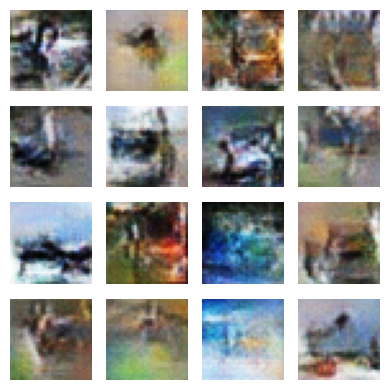

In [ ]:
inference_step()

<class 'tensorflow.python.framework.ops.EagerTensor'>
(16, 32, 32, 3)


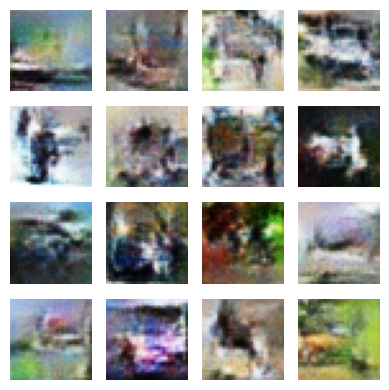

In [ ]:
inference_step()

<class 'tensorflow.python.framework.ops.EagerTensor'>
(16, 32, 32, 3)


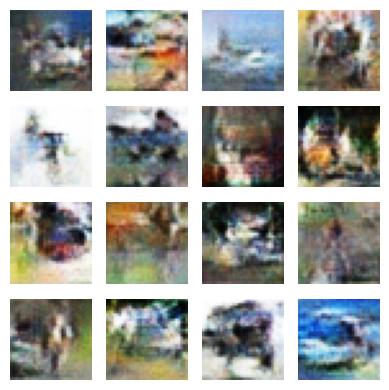

In [ ]:
inference_step()

<class 'tensorflow.python.framework.ops.EagerTensor'>
(16, 32, 32, 3)


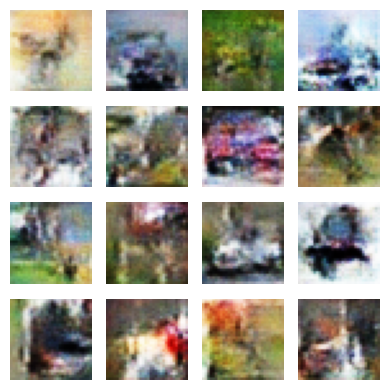

In [ ]:
inference_step()

<class 'tensorflow.python.framework.ops.EagerTensor'>
(16, 32, 32, 3)


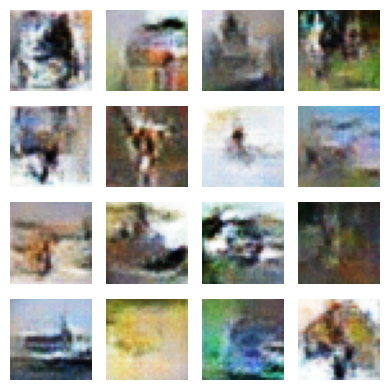

In [ ]:
inference_step()

<class 'tensorflow.python.framework.ops.EagerTensor'>
(16, 32, 32, 3)


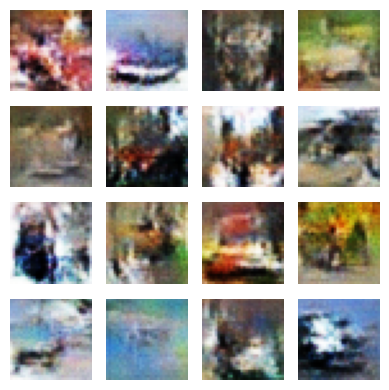

In [ ]:
inference_step()

<class 'tensorflow.python.framework.ops.EagerTensor'>
(16, 32, 32, 3)


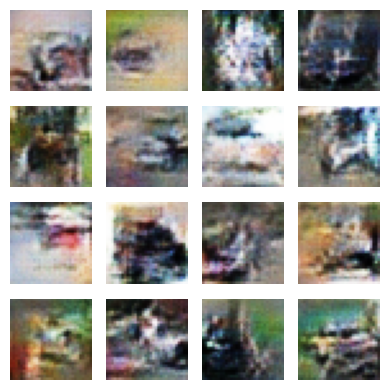

In [ ]:
inference_step()

<class 'tensorflow.python.framework.ops.EagerTensor'>
(16, 32, 32, 3)


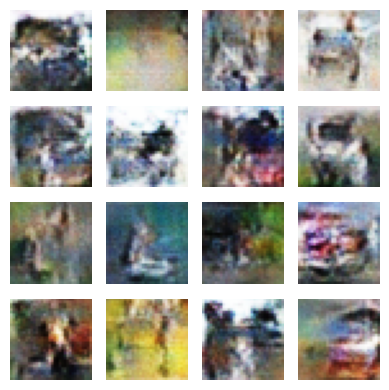

In [ ]:
inference_step()

<class 'tensorflow.python.framework.ops.EagerTensor'>
(16, 32, 32, 3)


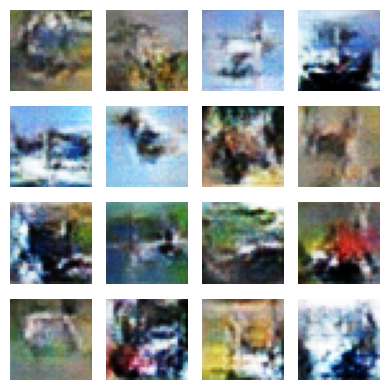

In [ ]:
inference_step()

<class 'tensorflow.python.framework.ops.EagerTensor'>
(16, 32, 32, 3)


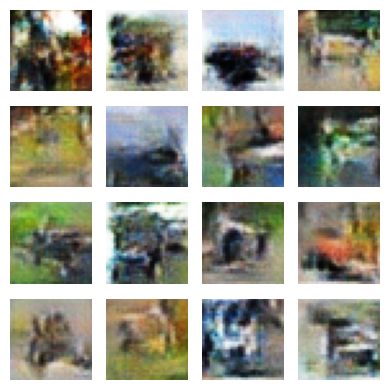

In [ ]:
inference_step()

<class 'tensorflow.python.framework.ops.EagerTensor'>
(16, 32, 32, 3)


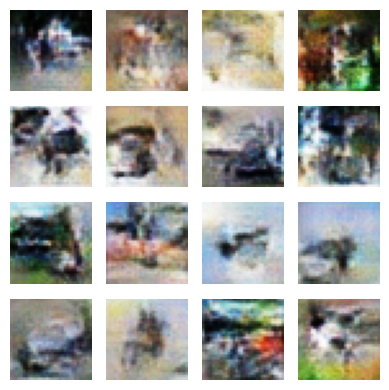

In [ ]:
inference_step()

<class 'tensorflow.python.framework.ops.EagerTensor'>
(16, 32, 32, 3)


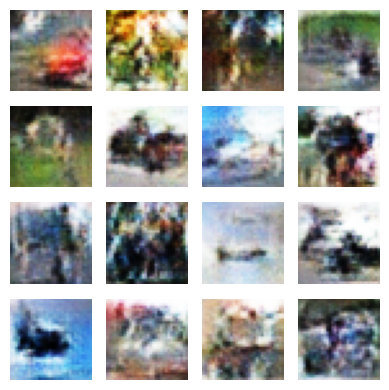

In [ ]:
inference_step()

<class 'tensorflow.python.framework.ops.EagerTensor'>
(16, 32, 32, 3)


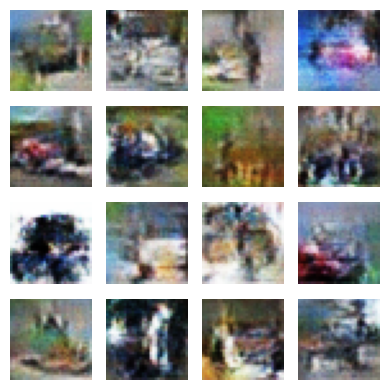

In [ ]:
inference_step()

<class 'tensorflow.python.framework.ops.EagerTensor'>
(16, 32, 32, 3)


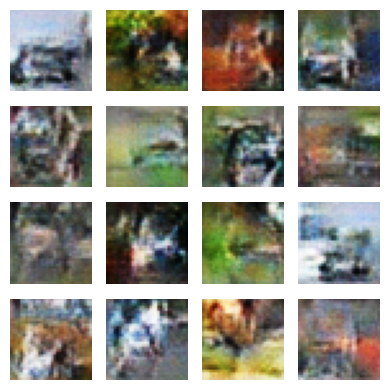

In [ ]:
inference_step()

<class 'tensorflow.python.framework.ops.EagerTensor'>
(16, 32, 32, 3)


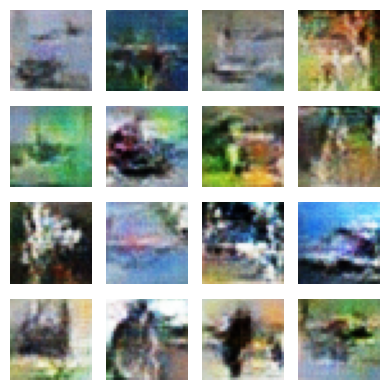

In [ ]:
inference_step()

<class 'tensorflow.python.framework.ops.EagerTensor'>
(16, 32, 32, 3)


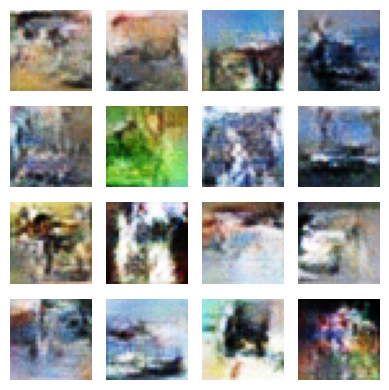

In [ ]:
inference_step()

<class 'tensorflow.python.framework.ops.EagerTensor'>
(16, 32, 32, 3)


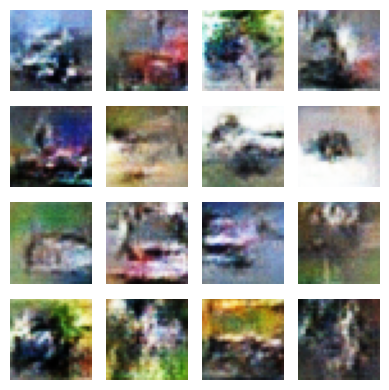

In [ ]:
inference_step()

### Results with 4 epochs and -62 for Generator Loss

<class 'tensorflow.python.framework.ops.EagerTensor'>
(16, 32, 32, 3)


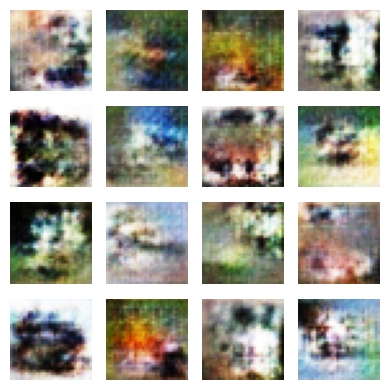

In [ ]:
inference_step()

<class 'tensorflow.python.framework.ops.EagerTensor'>
(16, 32, 32, 3)


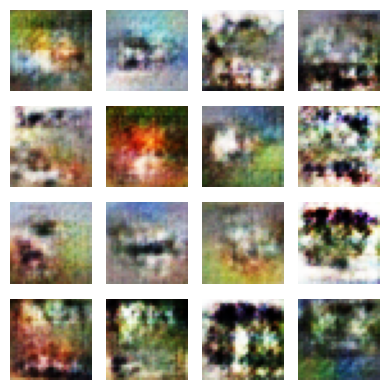

In [ ]:
inference_step()

<class 'tensorflow.python.framework.ops.EagerTensor'>
(16, 32, 32, 3)


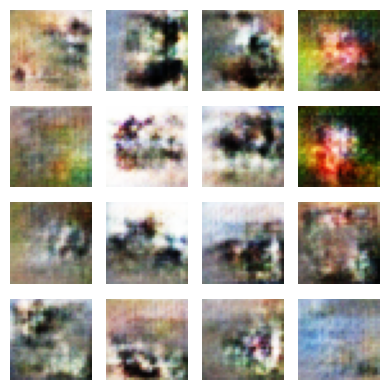

In [ ]:
inference_step()

<class 'tensorflow.python.framework.ops.EagerTensor'>
(16, 32, 32, 3)


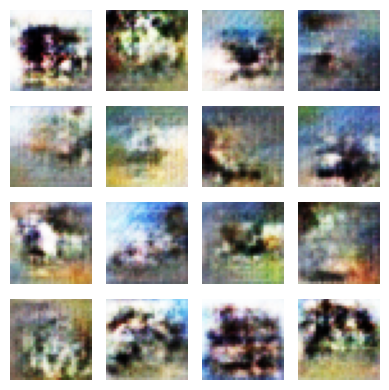

In [ ]:
inference_step()

<class 'tensorflow.python.framework.ops.EagerTensor'>
(16, 32, 32, 3)


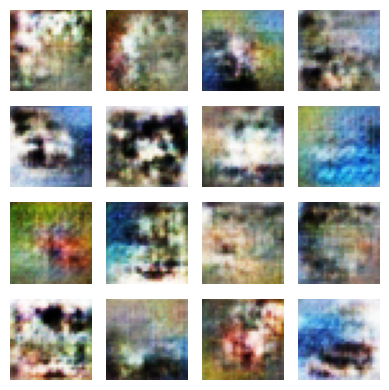

In [ ]:
inference_step()